TODO: Incorporate notebook into 00_utils / 00_core.

# Experiments: Waveform Shape

> Can an amplitude waveform help detect when *something* occurs?

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%matplotlib inline

In [ ]:
# hide
import warnings; warnings.filterwarnings(action='ignore', category=UserWarning, module=r'librosa')

In [ ]:
from rcfx_species_audio_detection.utils import *

In [ ]:
import librosa
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
n_fft = 2048
hop_length = 512
n_mels= 128

In [ ]:
path = Path('sample_data')

Audio Waveform

In [ ]:
for audio_file in (path/'train').iterdir():
    if audio_file.suffix != '.flac': continue
    wf,sr = librosa.load(audio_file, sr=None)
    break

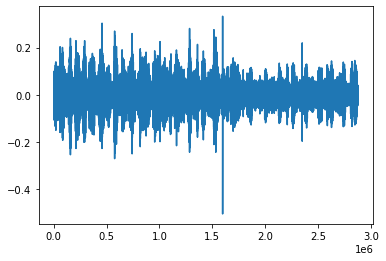

In [ ]:
plt.plot(wf)

Load detections

In [ ]:
train_tp = pd.read_csv(path/'train_tp.csv')

In [ ]:
audio_files = [f for f in (path/'train').iterdir() if f.suffix == '.flac']
audio_files = list(map(lambda x: x.stem, audio_files))

Use an audio that's in the sample dataset

In [ ]:
for rec_id in train_tp['recording_id']:
    if rec_id in audio_files:
        print(rec_id)
        break

003bec244


In [ ]:
wf,sr = librosa.load(path/f'train/{rec_id}.flac', sr=None)

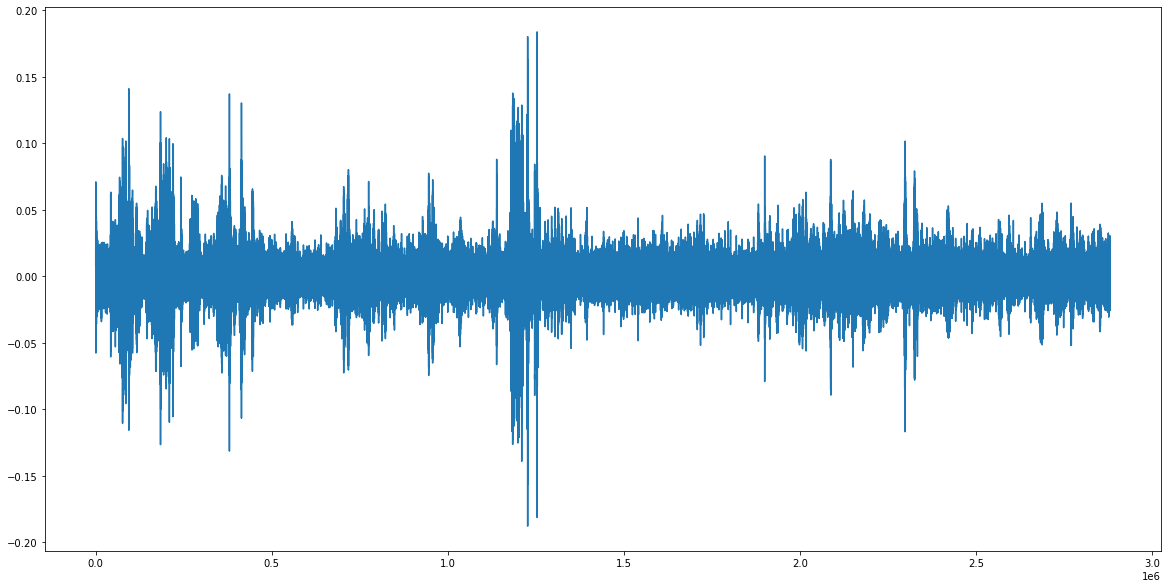

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(wf);

Find it's detection's start and end time stamps

In [ ]:
t_min,t_max = train_tp.loc[train_tp['recording_id']==rec_id].loc[:,['t_min','t_max']].values[0]
t_min,t_max

(44.544, 45.1307)

View waveform at detection window

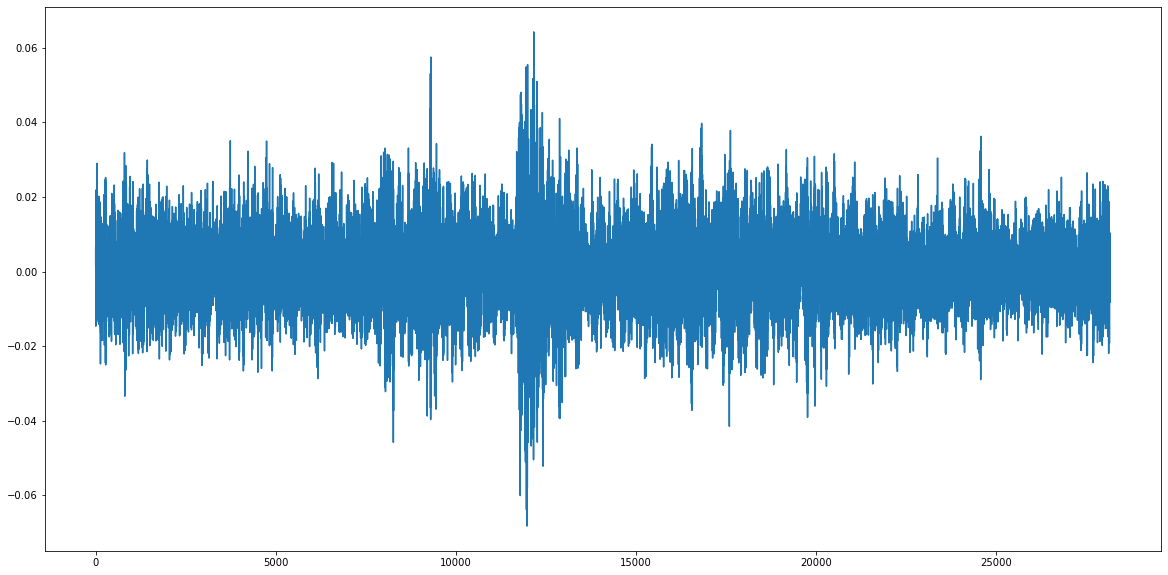

In [ ]:
plt.figure(figsize=(20,10)), plt.plot(wf[int(sr*t_min):int(sr*t_max)]);

Outline detection in full waveform

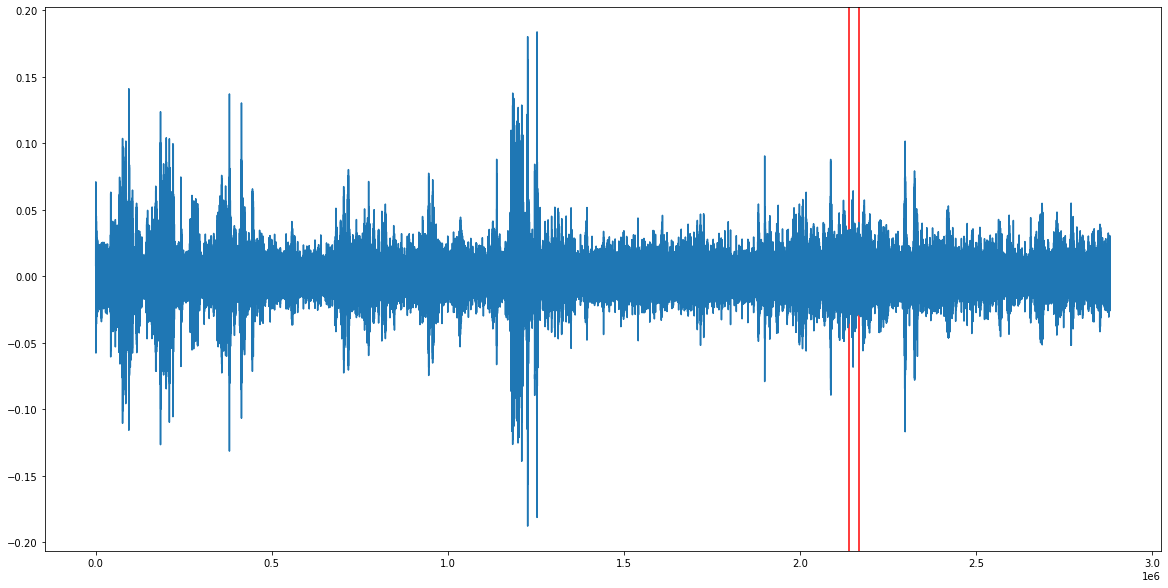

In [ ]:
plt.figure(figsize=(20,10))
plt.axvline(x=int(sr*t_min), color='r'); plt.axvline(x=int(sr*t_max), color='r')
plt.plot(wf)

That looks like it's going to be tough.

In [ ]:

def display_detection_window_waveform(rec_id,csv_fpath,audio_path,codec='flac',figsize=(20,10)):
    # load
    wf,sr = librosa.load(audio_path/f'{rec_id}.{codec}', sr=None)
    csv_file = pd.read_csv(csv_fpath)
    t_min,t_max = csv_file.loc[csv_file['recording_id']==rec_id].loc[:,['t_min','t_max']].values[0]
    # full waveform
    plt.figure(figsize=figsize)
    plt.axvline(x=int(sr*t_min), color='r'); plt.axvline(x=int(sr*t_max), color='r')
    plt.title(f'{audio_path.name} waveform')
    plt.plot(wf)
    # zoomed waveform
    plt.figure(figsize=(20,10))
    plt.title(f'{audio_path.name} detection')
    plt.plot(wf[int(sr*t_min):int(sr*t_max)], linewidth=0.5)

find the longest length annotation

In [ ]:

def get_annotation_length(csv_file, rec_id):
    t_min,t_max = csv_file.loc[csv_file['recording_id']==rec_id].loc[:,['t_min','t_max']].values[0]
    return t_max - t_min

Find max length of all annotations:

In [ ]:
train_tp = pd.read_csv(path/'train_tp.csv')
train_fp = pd.read_csv(path/'train_fp.csv')

In [ ]:
def find_longest_annotations(csv_file, n=1):
    """
    Find length and row-index of the N longest annotation windows.
    """
    l_dict = {}
    for rdx in range(len(csv_file)):
        t_min,t_max = csv_file.iloc[rdx].loc[['t_min','t_max']]
        l = t_max - t_min
        l_dict[rdx] = l
    return sorted(list(l_dict.items()), key=lambda x: x[1], reverse=True)[:n]

In [ ]:
find_longest_annotations(train_tp, n=10), find_longest_annotations(train_fp, n=10)

([(107, 7.923900000000003),
  (587, 7.923900000000003),
  (854, 7.923900000000003),
  (402, 7.923800000000007),
  (481, 7.923800000000007),
  (352, 7.9238000000000035),
  (566, 7.9238000000000035),
  (1017, 7.923800000000001),
  (28, 7.9238),
  (29, 7.9238)],
 [(510, 7.923900000000003),
  (1486, 7.923900000000003),
  (2332, 7.923900000000003),
  (2867, 7.923900000000003),
  (4535, 7.923900000000003),
  (4567, 7.923900000000003),
  (5131, 7.923900000000003),
  (1334, 7.9239000000000015),
  (6018, 7.9239000000000015),
  (6252, 7.9239000000000015)])

In [ ]:
train_fp = pd.read_csv(path/'train_fp.csv')

In [ ]:
len(train_fp)

7781

In [ ]:
train_tp['recording_id'].unique().shape, train_fp['recording_id'].unique().shape

((1132,), (3958,))

In [ ]:
rec_list = np.concatenate((train_tp['recording_id'].unique(), train_fp['recording_id'].unique()))

In [ ]:
rec_list.shape, np.unique(rec_list).shape

((5090,), (4727,))

In [ ]:
train_tp.shape

(1216, 7)

In [ ]:
train_tp

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20


In [ ]:
np.random.choice(audio_files)

'01a976045'

In [ ]:
filelist = train_tp['recording_id'].values.tolist()

In [ ]:
rec_id = '003b04435'
rec_id in filelist

False

In [ ]:
audio_files

['00d442df7',
 '0072f0839',
 '00f3b3c1e',
 '017165b59',
 '00834f88e',
 '011f25080',
 '003bec244',
 '016240b9a',
 '015aa6c7c',
 '0099c367b',
 '0178fe09a',
 '00204008d',
 '00b404881',
 '00ad36516',
 '0171866c7',
 '005f1f9a5',
 '013716dbf',
 '00e3525a2',
 '0151b7d20',
 '0079ff47b',
 '003b04435',
 '01a976045',
 '007f87ba2',
 '009aa1c8f',
 '015113cad',
 '008c9c381',
 '009b760e6',
 '006ab765f',
 '017d43bd0',
 '009fbc7b4']

In [ ]:
train_tp.loc[train_tp['recording_id']=='003b04435']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max


In [ ]:
len(train_tp)

1216

In [ ]:
%debug

> <ipython-input-98-6443f75c422f>(6)display_detection_window_waveform()
      4     wf,sr = librosa.load(audio_path/f'{rec_id}.{codec}', sr=None)
      5     csv_file = pd.read_csv(csv_fpath)
----> 6     t_min,t_max = csv_file.loc[csv_file['recording_id']==rec_id].loc[:,['t_min','t_max']].values[0]
      7     # full waveform
      8     plt.figure(figsize=figsize)

ipdb> rec_id
'003b04435'
ipdb> csv_file.loc[csv_file['recording_id']==rec_id].loc[:,['t_min','t_max']].values
array([], shape=(0, 2), dtype=float64)
ipdb> q


In [ ]:
display_detection_window_waveform(np.random.choice(audio_files), path/'train_tp.csv', path/'train/')

IndexError: index 0 is out of bounds for axis 0 with size 0

## notebook export

In [ ]:
from nbdev.export import notebook2script; notebook2script()